# Importing Libraries

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from matplotlib import pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from sklearn import linear_model

In [6]:
from sklearn.cluster import KMeans

In [7]:
from sklearn.decomposition import PCA

In [8]:
from sklearn.pipeline import Pipeline

In [9]:
from sklearn.preprocessing import StandardScaler

# Reading Dataset & Merging

In [10]:
Data1 = pd.read_csv(r'C:\\Users\\datta\\Downloads\\road-accidents.csv')
Data2 = pd.read_csv(r'C:\\Users\datta\\Downloads\\miles-driven.csv')

In [11]:
Data1

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12.0,35,28,89
5,Colorado,13.6,37,28,95
6,Connecticut,10.8,46,36,82
7,Delaware,16.2,38,30,99
8,District of Columbia,5.9,34,27,100
9,Florida,17.9,21,29,94


In [12]:
Data2

,state,million_miles_annually
0,Alabama,64914
1,Alaska,4593
2,Arizona,59575
3,Arkansas,32953
4,California,320784
5,Colorado,46606
6,Connecticut,31197
7,Delaware,9028
8,District of Columbia,3568
9,Florida,191855


In [13]:
Data3 = pd.merge(Data1, Data2)

In [14]:
Data3

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,million_miles_annually
0,Alabama,18.8,39,30,80,64914
1,Alaska,18.1,41,25,94,4593
2,Arizona,18.6,35,28,96,59575
3,Arkansas,22.4,18,26,95,32953
4,California,12.0,35,28,89,320784
5,Colorado,13.6,37,28,95,46606
6,Connecticut,10.8,46,36,82,31197
7,Delaware,16.2,38,30,99,9028
8,District of Columbia,5.9,34,27,100,3568
9,Florida,17.9,21,29,94,191855


# Checking Null Values

In [15]:
missing_values_count = Data3.isnull().sum()

In [16]:
missing_values_count

state                     0
drvr_fatl_col_bmiles      0
perc_fatl_speed           0
perc_fatl_alcohol         0
perc_fatl_1st_time        0
million_miles_annually    0
dtype: int64

# Summarizing and Visualizing the data

In [17]:
Data3.sum()

state                     AlabamaAlaskaArizonaArkansasCaliforniaColorado...
drvr_fatl_col_bmiles                                                  805.3
perc_fatl_speed                                                        1618
perc_fatl_alcohol                                                      1565
perc_fatl_1st_time                                                     4525
million_miles_annually                                              2950402
dtype: object

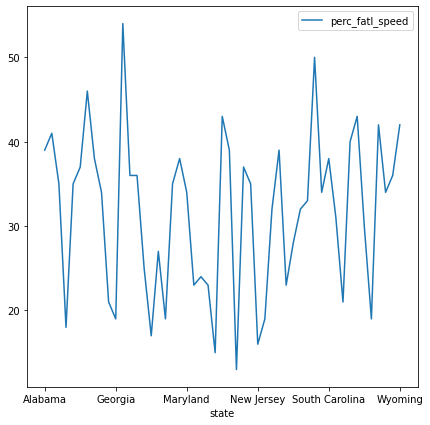

In [18]:
Data3.plot(x="state", y=["perc_fatl_speed"],
         figsize=(7, 7))
plt.show()

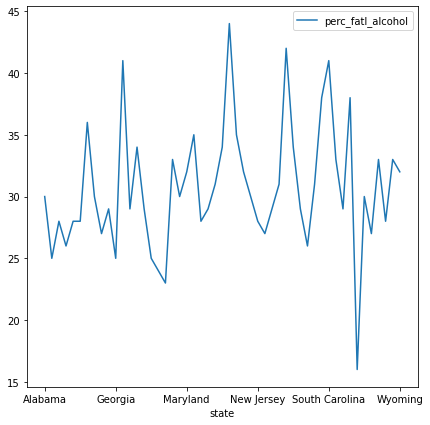

In [19]:
Data3.plot(x="state", y=["perc_fatl_alcohol"],
         figsize=(7, 7))
plt.show()


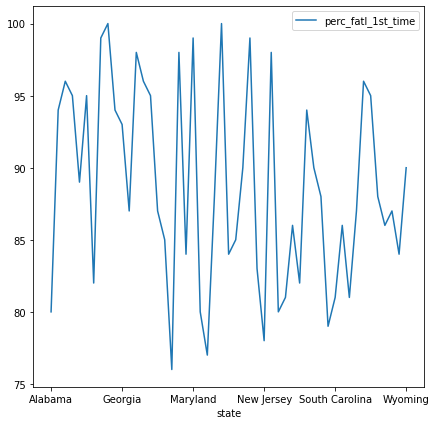

In [20]:
Data3.plot(x="state", y=["perc_fatl_1st_time"],
         figsize=(7, 7))
plt.show()

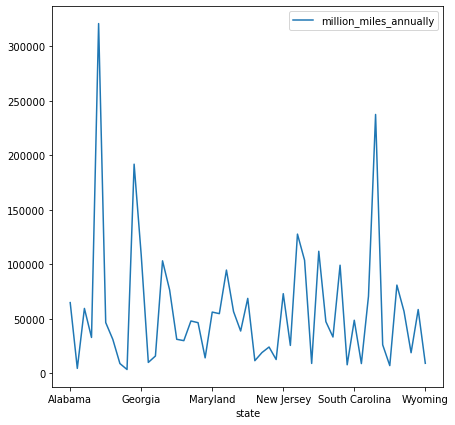

In [21]:
Data3.plot(x="state", y=["million_miles_annually"],
         figsize=(7, 7))
plt.show()

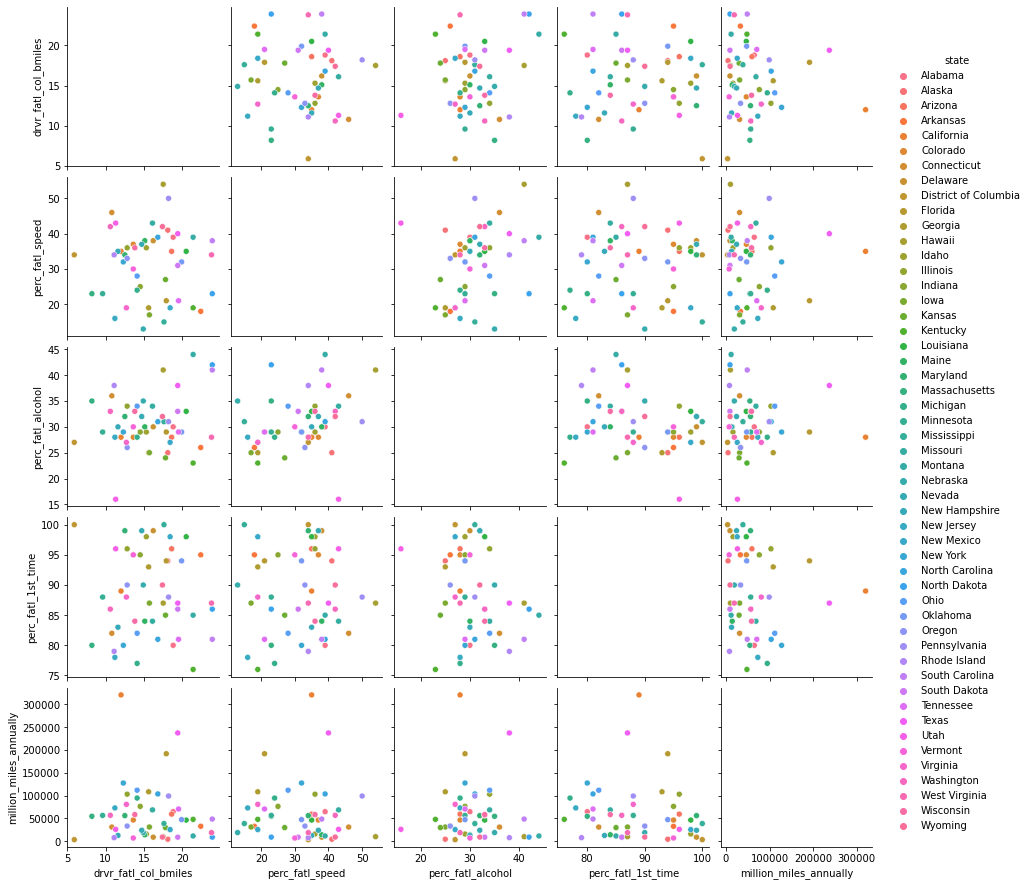

In [22]:
sns.pairplot(Data3, hue="state")
plt.show()

# Correalation Coeffecient and fitting Multivariate Linear Regression 

In [23]:
Data3.corr()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,million_miles_annually
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942,-0.077133
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066,-0.043199
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455,-0.034561
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000,-0.128928
million_miles_annually,-0.077133,-0.043199,-0.034561,-0.128928,1.000000


In [24]:
y = Data3['drvr_fatl_col_bmiles']
X = Data3[['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time', ]]

regr = linear_model.LinearRegression()
regr.fit(X, y)
print(f"coefficients: {regr.coef_}")

coefficients: [-0.04180041  0.19086404  0.02473301]


# Perform PCA on Standardized Data

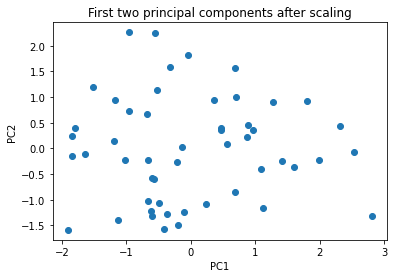

In [25]:
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)
pca = PCA(n_components=2)
pca_comp = pca.fit_transform(X_scaled)

pca_comp1 = pca_comp[:,0]
pca_comp2 = pca_comp[:,1]
plt.scatter(pca_comp1,pca_comp2)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components after scaling")
plt.show()


# Scree Plot

C:\Users\datta\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


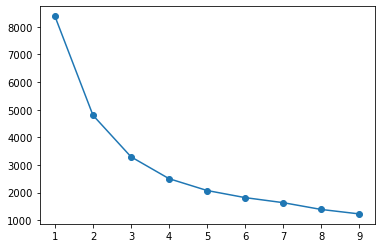

In [26]:
z = range(1, 10)
inertias = []
for k in z:
    
    km = KMeans(n_clusters= k, random_state=8)
    km.fit(X)
    inertias.append(km.inertia_)
    

plt.plot(z, inertias, marker='o')
plt.show()

# PCA scatter plot

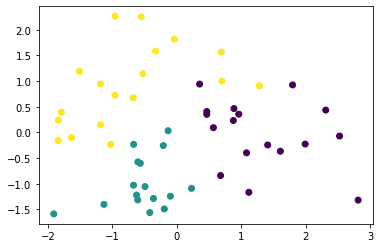

In [27]:
km = KMeans(n_clusters = 3, random_state=8)

km.fit(X)
plt.scatter(pca_comp1, pca_comp2, c=km.labels_)
plt.show()

# Visualizing the feature differences between the clusters

<AxesSubplot:xlabel='percent', ylabel='measurement'>

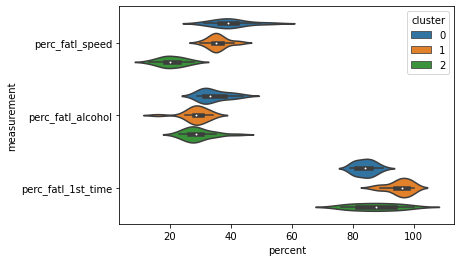

In [28]:
Data3['cluster'] = km.labels_

melt_car = pd.melt(Data3, id_vars='cluster', var_name='measurement', value_name='percent',
                   value_vars=['perc_fatl_speed', 'perc_fatl_alcohol', 'perc_fatl_1st_time'])

# Create a violin plot splitting and coloring the results according to the km-clusters
sns.violinplot(y='measurement', x='percent', data=melt_car, hue='cluster')

# Computing the number of accidents within each cluster

,count,mean,sum
cluster,,,
0,17,951.709165,16179.0558
1,16,727.207806,11635.3249
2,18,990.046094,17820.8297


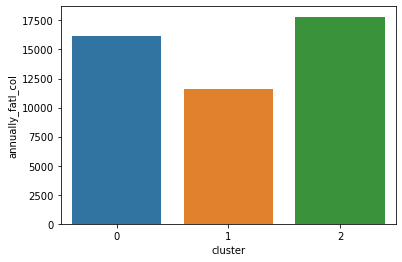

In [29]:
# Create a new column for the number of drivers involved in fatal accidents
Data3['annually_fatl_col'] = (Data3['drvr_fatl_col_bmiles'] * Data3["million_miles_annually"])/1000

# Create a barplot of the total number of accidents per cluster
sns.barplot(x='cluster', y='annually_fatl_col', data=Data3, estimator=sum, ci=None)

# Calculate the number of states in each cluster and their 'num_drvr_fatl_col' mean and sum.
count_mean_sum = Data3.groupby("cluster")["annually_fatl_col"].agg(["count", "mean", "sum"])
count_mean_sum

## Since Cluster 2 has highest accidents per million miles driven annually, it should be focused for policy intervention and further investigation